In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

In [12]:
# Load dataset
df = pd.read_csv("dataset.csv")

In [13]:

# Basic dataset info
print("Dataset shape:", df.shape)
df.info()
print("Missing values:")
print(df.isnull().sum())

Dataset shape: (383, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response       

<ipython-input-14-05a95e348065>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Recurred", data=df, palette="viridis")


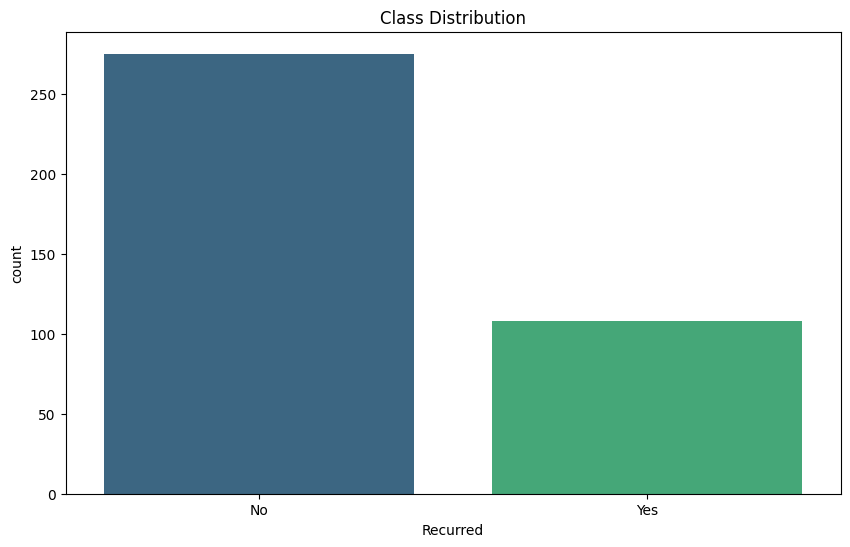

In [14]:

# Data visualization
plt.figure(figsize=(10, 6))
sns.countplot(x="Recurred", data=df, palette="viridis")
plt.title("Class Distribution")
plt.show()

In [15]:
# Verify available columns
available_columns = df.columns.tolist()

In [16]:
# Feature categorization (only include existing columns)
categorical_features = [col for col in ["Gender", "Smoking", "Hx_Smoking", "Hx_Radiotherapy", "Thyroid_Function", "Physical_Examination", "Adenopathy", "Pathology", "Focality", "Risk", "Response", "T", "N", "M", "Stage"] if col in available_columns]
numerical_features = [col for col in ["Age"] if col in available_columns]
target_column = "Recurred"

In [17]:
# Convert target variable to numerical format
if df[target_column].dtype == 'object':
    df[target_column] = LabelEncoder().fit_transform(df[target_column])

In [18]:
# Data Preprocessing Pipelines
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, numerical_features),
    ("cat", cat_transformer, categorical_features)
])

In [19]:
# Split data
X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)

In [21]:
# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb_model)
])


In [22]:

# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb_model)
])

In [23]:

# Hyperparameter tuning
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.7, 1.0]
}

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEnco...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.7, 1.0]},
             scoring='roc_auc', verbose=2)

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report



In [25]:
# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.974025974025974
Precision: 1.0
Recall: 0.9090909090909091
F1 Score: 0.9523809523809523
ROC AUC: 0.9545454545454546

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77



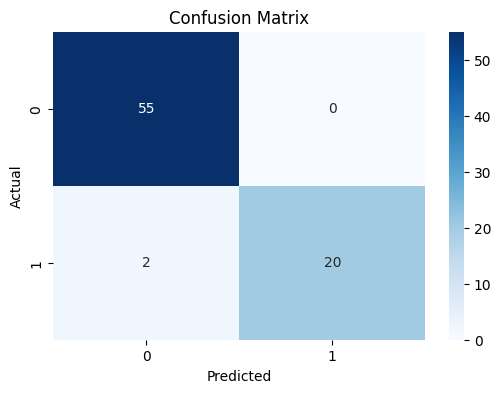

In [27]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Feature Importance
feature_importance = best_model.named_steps["classifier"].feature_importances_
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
feature_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

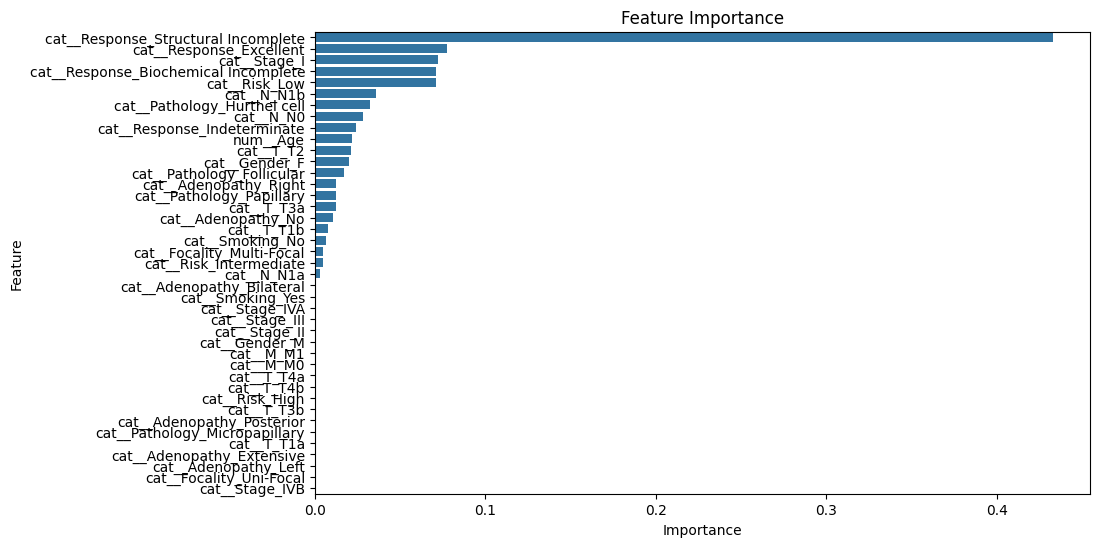

In [29]:


plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_df)
plt.title("Feature Importance")
plt.show()


In [30]:
!pip install joblib
import joblib

# Save the model
joblib.dump(best_model, "thyroid_cancer_model.pkl")
print("Model saved as thyroid_cancer_model.pkl")

Model saved as thyroid_cancer_model.pkl


In [31]:
# Test model with sample data
sample_data = pd.DataFrame([{ "Age": 45, "Gender": "Male", "Smoking": "No", "Hx_Smoking": "No", "Hx_Radiotherapy": "Yes", "Thyroid_Function": "Normal", "Physical_Examination": "Normal", "Adenopathy": "No", "Pathology": "Papillary", "Focality": "Unifocal", "Risk": "Low", "T": "T1", "N": "N0", "M": "M0", "Stage": "I", "Response": "Positive" }])

sample_data_processed = best_model.named_steps["preprocessor"].transform(sample_data)
sample_prediction = best_model.named_steps["classifier"].predict(sample_data_processed)
print("Sample prediction (0: No recurrence, 1: Recurrence):", sample_prediction[0])

Sample prediction (0: No recurrence, 1: Recurrence): 0
